In [21]:
from sympy.abc import s
from utils.units import u
from sympy import sqrt
from IPython.display import display

l = 2.5*u.mH
c = 60*u.uF
r = 2*u.ohm
vcc = 450*u.V
vpp = 30*u.V
ks = 3/220*sqrt(2)

gp = 2*vcc/vpp*1/(l*c*s**2+l/r*s+1)
display(gp)

ts = 1*u.ms
mp = 10*u.percent

30/(150.0*microfarad*millihenry*s**2 + 1.25*millihenry*s/ohm + 1)

In [22]:
from utils.units import basis

nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=4388549412611122592), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [23]:
from utils.units.sympy_helpers import split_unit_form as split_unit
u2symb = lambda unit, value, n=4: split_unit(nu.to_symb(unit, value).n(n))

In [24]:
from utils.ctrlsys import pole_specs

_, dp_s = pole_specs(nu[ts], nu[mp])

display(u2symb(u.kHz, dp_s))

wn = abs(dp_s)
u2symb(u.kHz, wn)

kilohertz*(-3.912 + 5.337*I)

6.618*kilohertz

In [25]:
dt = 1/(10*wn)
u2symb(u.us, dt)

15.11*microsecond

In [26]:
from utils.ctrl import sys_deu
from utils.ctrlsys import s2tf
from control import matlab as m

z_dtf = m.tf("z")
one_dtf = (z_dtf/z_dtf).minreal()

to_tf = lambda expr: s2tf(nu.to_numeric(expr, as_expr=True), s)

gp_tf = to_tf(gp)
gp_dtf = m.c2d(gp_tf, dt)
sys_deu(gp_dtf, nu, 1, 1)
gs_dtf = one_dtf*nu[ks]

gls = {
    "sensor": gs_dtf,
    "planta": gp_dtf
}

In [27]:
from utils.ctrlsys import z_map
from sympy import sympify

dp = z_map(dp_s, dt)
sympify(dp).n(4)

0.9395 + 0.07594*I

In [28]:
from sympy import symbols
from utils.ratpolys import f2zpk
from sympy.abc import z
kc, a = symbols("K_c a", real=True, positive=True)

gc = kc*(z-a)/z
gc_poles = list(f2zpk(gc, z)[1].keys())
assert gc_poles == [0]
gc_poles = [float(p) for p in gc_poles]
gc_poles

[0.0]

In [29]:
def scatter_syss(syss, sp, sz):
    for name, sys in syss.items():
        sp(sys.pole(), label=f"Polos de {name}")
        sz(sys.zero(), label=f"Ceros de {name}")

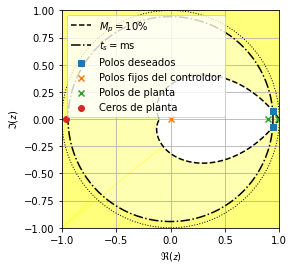

In [30]:
from utils.ctrlsys import zp_plot
from utils.mpl import latex_notext as lt
from utils.math import with_conj

fig, ax, (
    (add_ucircle, add_ts_max, add_mp_max),
    (scatter_poles, scatter_zeros)) = zp_plot()
ax.set_ylim((-1, 1))
ax.set_xlim((-1, 1))
ax.grid()

scatter_poles(with_conj(dp), label="Polos deseados", marker='s')
scatter_poles(gc_poles, label="Polos fijos del controldor")
scatter_syss(gls, scatter_poles, scatter_zeros)

ax.set_axisbelow(True)
add_ucircle()
add_mp_max(nu[mp], label=f"$M_p={lt(mp)}$", linestyle="--")
add_ts_max(nu[ts], nu[dt], label=f"$t_s={lt(ts)}$")

#fig.legend(loc="upper right", bbox_to_anchor=(1.1, .87))
ax.legend()
ax.set_aspect(1)

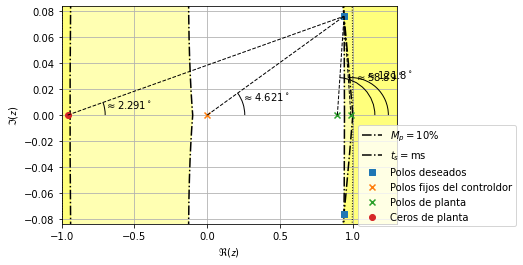

In [31]:

from utils.mpl.annotations import annotate_angle
from utils.math import angle_between, reim
from utils.misc import concat

fig, ax, (
    (add_ucircle, add_ts_max, add_mp_max),
    (scatter_poles, scatter_zeros)) = zp_plot()
#ax.set_ylim((-.4, .4))
ax.set_xlim((-1, 1.3))
ax.grid()

def rloc_angle(p, dp, line_kwargs={}, **kwargs):
    annotate_angle(reim(p), reim(p+1), reim(dp), ax,
        lambda *args: "$\\approx {}$".format(
            lt(nu.to_symb(u.deg, angle_between(*args)).n(4))),
            **kwargs)
    ax.plot([p.real, dp.real], [p.imag, dp.imag],
        linestyle="--", c='k', linewidth=1, **line_kwargs)

for sys in gls.values():
    for point in concat(sys.pole(), sys.zero()):
        rloc_angle(point, dp, textposition="outside")
[rloc_angle(gc_pole, dp, textposition="outside") for gc_pole in gc_poles]

scatter_poles(with_conj(dp), label="Polos deseados", marker='s')
scatter_poles(gc_poles, label="Polos fijos del controldor")
scatter_syss(gls, scatter_poles, scatter_zeros)

ax.set_axisbelow(True)
add_ucircle()
add_mp_max(nu[mp], label=f"$M_p={lt(mp)}$")
add_ts_max(nu[ts], nu[dt], label=f"$t_s={lt(ts)}$")

fig.legend(loc="lower left", bbox_to_anchor=(.8, .1))

In [32]:
from utils.ctrlsys import phase_def
from utils.misc import concat


In [33]:
from itertools import starmap
from more_itertools import unzip
from utils.math import arg_ex
import sympy as sp

def sys_pz(sys):
    return sys.pole(), sys.zero()

def rlocus_design_phase_eq(dp, z, gc, *syss, plus=True, arg=arg_ex):
    controller_arg = arg(gc.subs(z, dp))
    zeros, poles = starmap(concat, unzip(map(sys_pz, syss)))
    fixed_arg = phase_def(dp, poles, zeros)
    return (sp.pi if plus else -sp.pi)+controller_arg-fixed_arg

a_ = sp.nsolve(
    rlocus_design_phase_eq(
        dp, z, gc, *gls.values(), plus=False),
    0)
a_ = float(a_)
a_

0.24753825136099927

In [34]:
from utils.ctrl import siso_tf2k as sys_gain
from utils.ctrlsys import mag_def
from functools import reduce
from operator import mul

def rlocus_design_mag_eq(dp, z, gc, *syss):
    controller_mag = abs(gc.subs(z, dp))
    poles, zeros = starmap(
        concat, unzip(map(sys_pz, syss)))
    gain = reduce(mul, map(sys_gain, syss), 1)
    fixed_mag = mag_def(dp, poles, zeros)/gain
    return controller_mag/fixed_mag-1

kc_ = sp.nsolve(
    rlocus_design_mag_eq(
        dp, z, gc.subs(a, a_), *gls.values()),
    1)
kc_ = float(kc_)
kc_

13.366655481685928

In [35]:
sys_gain(gs_dtf)

0.01928473039599675

In [36]:
gc_dtf = sp.lambdify([z], gc.subs({kc: kc_, a: a_}))(z_dtf)
gc_dtf

gcl_dtf = m.feedback(gp_dtf*gc_dtf, gs_dtf)

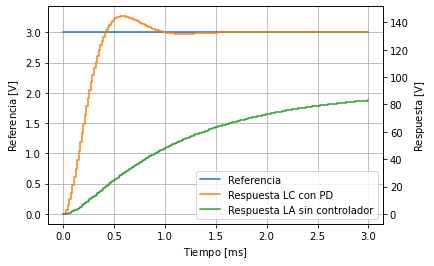

In [37]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrlsys import step, zoh_stairs
import numpy as np
my_step = lambda sys: lambda T=None: reversed(m.step(sys, T=T))

fig, (ax_e, ax_r), get_color, post = io_axes()
nu_twinx_axes(nu, ax_e, ax_r,
    ("Tiempo", u.ms),
    ("Referencia", u.V),
    ("Respuesta", u.V)
)

t = np.arange(0, nu[ts*3], nu[dt])
ampl = nu[3*u.V]
_, (ref, resp) = step(my_step(gcl_dtf), ampl=ampl, t=t)
_, (_, resp_nc) = step(my_step(gp_dtf), ampl=ampl, t=t)
ax_e.plot(t, ref, c=get_color(), label="Referencia")
ax_r.plot(*zoh_stairs(t, resp), c=get_color(), label="Respuesta LC con PD")
ax_r.plot(*zoh_stairs(t, resp_nc), c=get_color(), label="Respuesta LA sin controlador")

ax_e.grid()
post(gcl_dtf.dcgain(), "lower right")

In [38]:
from utils.ctrl import nu_stepinfo
from utils.misc import repr_aligned, valmap
from control import matlab as m

print(repr_aligned(
    valmap(lambda x: x.n(4),
        nu_stepinfo(nu, u.ms, u.V, m.stepinfo(gcl_dtf), ampl=ampl))
))


{
    'RiseTime':         0.272*millisecond
    'SettlingTime':     0.8916*millisecond
    'SettlingMin':      119.6*volt
    'SettlingMax':      144.5*volt
    'Overshoot':        8.865*percent
    'Undershoot':       0
    'Peak':             144.5*volt
    'PeakTime':         0.5893*millisecond
    'SteadyStateValue': 132.8*volt
}


In [39]:
from sympy import Eq
from utils.ctrl import siso_numden

e, u = map(sp.Function, ["e", "u"])
k = sp.Symbol("k")

def recursive_eq(num, den, in_, out, k):
    den_offset = len(num)-len(den)
    a0, *den_tail = den
    sum_in = sum(a*in_(k-i+den_offset) for i, a in enumerate(num))
    sum_out = sum(a*out(k-i-1) for i, a in enumerate(den_tail))
    return Eq(out(k), (sum_in-sum_out)/a0)
    
recursive_eq(*siso_numden(gc_dtf), e, u, k).n(4)

Eq(u(k), 13.37*e(k) - 3.309*e(k - 1))

In [40]:
gcl_dtf

TransferFunction(array([ 0.29277132,  0.20826509, -0.06949319]), array([ 1.00000000e+00, -1.87460302e+00,  8.85695572e-01, -1.34015752e-03]), 4.166580320484666e-06)